# 두 번째 모델 훈련하기

이 노트북에서 첫 번째 모델의 단점을 극복하기 위한 특성을 사용해 두 번째 모델을 훈련합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer, 
    get_vectorized_series,
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features, 
    get_word_stats, 
    get_sentiment_score, 
    POS_NAMES,
    get_question_score_from_input
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haesun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

새로운 모델에 도움이 될만한 후보 특성을 추가합니다.

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

`ml_editor` 소스 코드를 확인하여 이 함수들의 기능을 확인해 보세요!

In [6]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:09<00:00, 839.97it/s]


In [7]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# 모델

이제 새로운 특성을 추가했으니 새 모델을 훈련해 보죠. 특성만 다르고 이전과 동일한 모델을 사용합니다.

In [8]:
# 특성을 새로 추가했으므로 데이터셋을 다시 나눕니다.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [9]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [10]:
y_train.value_counts()

False    3483
True     2959
Name: Score, dtype: int64

In [11]:
X_test.shape

(1529, 7799)

In [12]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [13]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참고
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.590, precision = 0.565, recall = 0.460, f1 = 0.507


In [14]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validation accuracy = 0.608, precision = 0.621, recall = 0.512, f1 = 0.561


다행히 이 모델은 이전 모델보다 성능이 더 높습니다! 새로운 모델과 벡터화 객체를 나중에 사용하기 위해 디스크에 저장하겠습니다.

In [15]:
model_path = Path("../models/model_2.pkl")
vectorizer_path = Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path) 
joblib.dump(vectorizer, vectorizer_path) 

['../models/vectorizer_2.pkl']

## 특성의 유용성 검증하기

그다음 특성 중요도 [노트북](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/feature_importance.ipynb)에서 설명한 방법을 사용해 새로운 특성을 새로운 모델이 사용하는지 확인해 보겠습니다.

In [16]:
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [17]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances:

num_chars: 0.0083
ADJ: 0.0081
num_periods: 0.0079
num_diff_words: 0.0078
num_commas: 0.0069
num_questions: 0.0068
ADV: 0.0067
AUX: 0.0067
num_words: 0.0067
DET: 0.0065
VERB: 0.0062
PUNCT: 0.0062
polarity: 0.0061
NOUN: 0.0059
num_stops: 0.0058
PART: 0.0057
ADP: 0.0057
PRON: 0.0055
SCONJ: 0.0055
avg_word_len: 0.0053

Bottom 20 importances:

fundamentally: 0
begging: 0
fyi: 0
gains: 0
gay: 0
gazing: 0
gear: 0
gently: 0
glowing: 0
spiteful: 0
gesture: 0
spirits: 0
giants: 0
gimmick: 0
spinning: 0
spine: 0
glancing: 0
battles: 0
glare: 0
hearts: 0


새로운 특성이 가장 예측 성능이 좋은 편이군요! 반대로 TF-IDF 벡터화로 얻은 단어 벡터는 특별히 도움이 되는 것 같지 않습니다. 이어지는 [노트북](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/third_model.ipynb)에서 이런 특성을 제외하고 세 번째 모델을 훈련하여 어떤 성능을 내는지 확인해 보습니다.

## 예측과 데이터 비교하기

이 섹션은 새로운 모델로 데이터와 예측 비교하기 [노트북](comparing_data_to_predictions.ipynb)에서 설명한 평가 방법을 사용합니다.

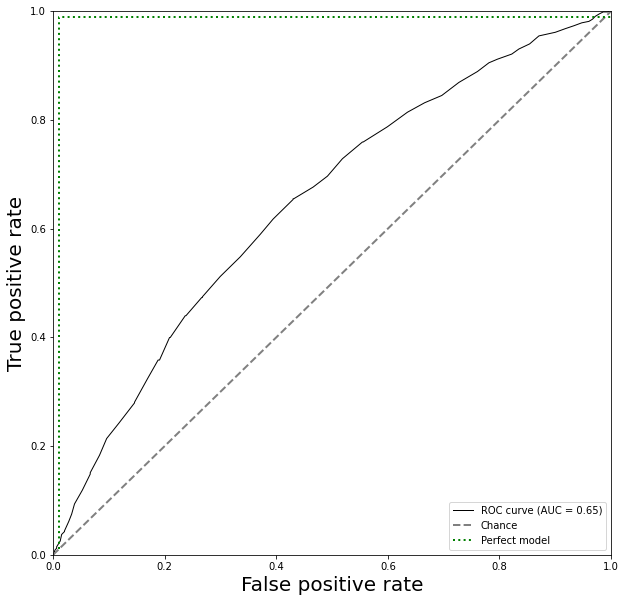

In [18]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

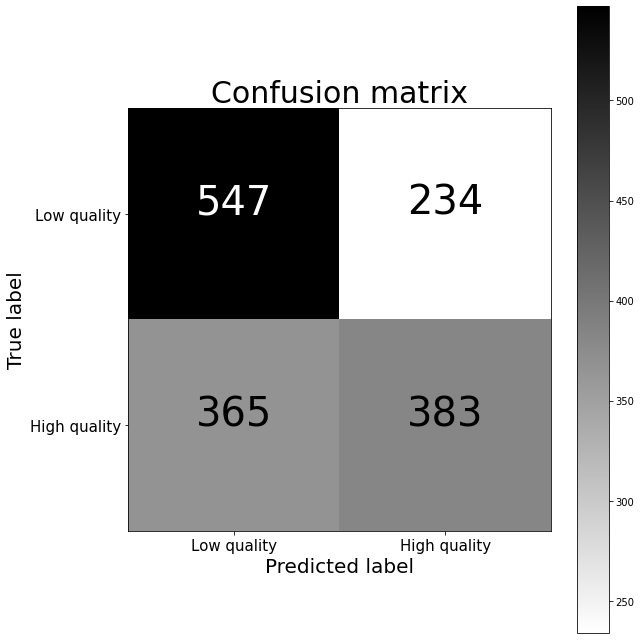

In [19]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.235


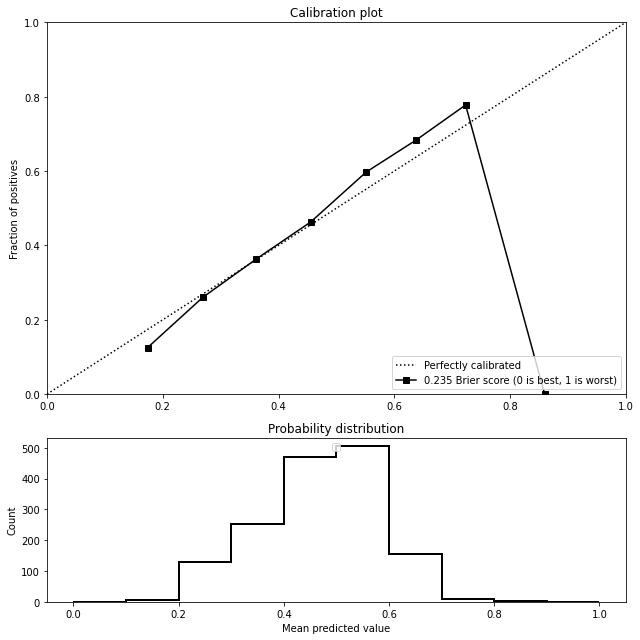

In [20]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

## Inference Function

Just like for our first model, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [21]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 1236.16it/s]

0.38 probability of the question receiving a high score according to our model
